![Melanoma](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSu_XRSf2Xas8xskONYgqD1y-MlbRXE-WGczQ&usqp=CAU)

## MELANOMA DETECTION ASSIGNMENT

### TABLE OF CONTENT
1. Importing libraries
2. Importing Dataset
3. Simple CNN Architecture
4. Data Augmentation 
5. Adding Dropout Layer
6. Batch Normalization
7. Handling Class imbalance
8. Final Model
9. Prediction on the dataset  

### 1. Importing all the important libraries

In [ ]:
## Importing important libraries
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import zipfile
import os


import tensorflow as tf
import PIL
from PIL import Image
import keras
# import Augmentor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Activation,Flatten,Dense,Rescaling,BatchNormalization
import tensorflow.keras.preprocessing.image as load_img
from keras.utils import image_dataset_from_directory
from keras.layers import RandomFlip,RandomRotation,RandomZoom




In [3]:
## Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
## Checking out the number of images included in the Test and Train set
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'There are {image_count_train} images in Train set')
print(f'There are {image_count_test} images in Test set')

There are 2239 images in Train set
There are 118 images in Test set


### 2. Create a dataset

In [7]:
### Defining parameters for the loader:
batch_size=32
img_height = 180
img_width = 180
epochs=20

In [8]:
## Using 80% of the images for training and the other for validation
train_ds,val_ds = image_dataset_from_directory(directory=data_dir_train,
                             labels='inferred',
                             class_names=None,
                             batch_size=32,
                             image_size=(img_height, img_width),
                             seed=123,
                             shuffle=True,
                             validation_split=0.2,
                             subset='both'
                            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [9]:
### Checking the class names we have got
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### Visualize the data

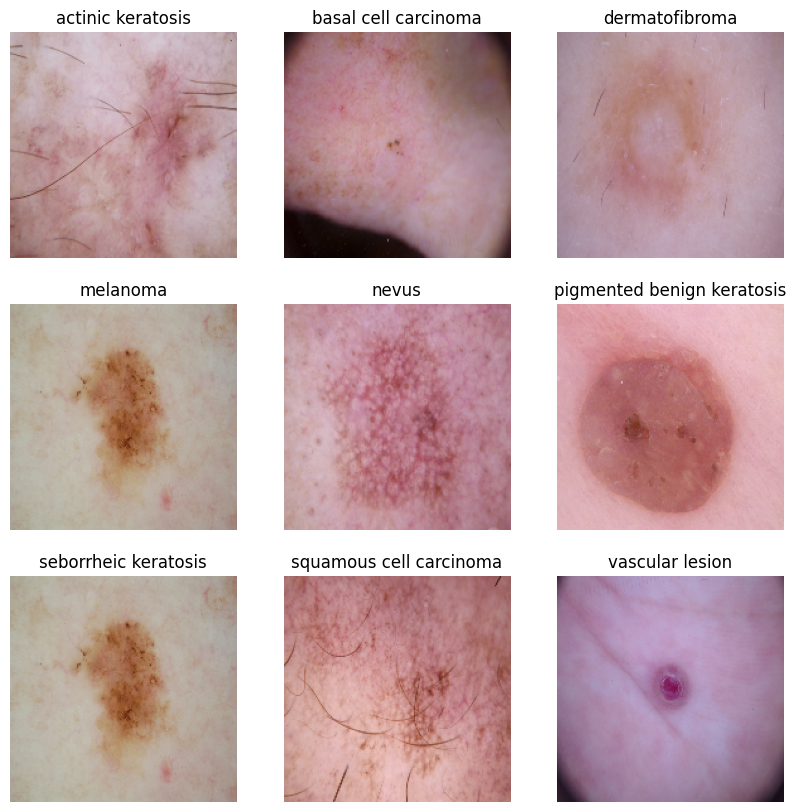

In [10]:
## Creating a dictionary which contains each label  and an image against that label
label_to_image= {}
for images,labels in train_ds:
    for image,label in zip(images,labels):
        label = label.numpy()
        if label not in label_to_image:
            ## Storing the first image for each label
            label_to_image[label] = image.numpy()
            break


### Plotting one image for each label using label_to_image
fig = plt.figure(figsize=(10,10))
for i in range(len(label_to_image)):
    ax = plt.subplot(3,3,i+1)
    image = label_to_image[i].astype('uint8')
    plt.imshow(image)
    plt.title(class_names[i])
    plt.axis('off')

#### 3. Simple CNN architecture

In [11]:
### Standardizing the data
normalizing_layer = layers.experimental.preprocessing.Rescaling(1./255)
num_classes=len(class_names)

In [12]:
## Autotuning for performance

### cache is used to load the images to disk and there is no need to load it again and again
### prefetch help us to preprocess the next batch of data when it is still processing the current one
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Building the first model

In [13]:
## Keeping the model architecture simple enough
model = Sequential([
  normalizing_layer,                                                                       ## to convert image in the range of 0 to 1
  Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height,img_width,3)),  ## first convolution layer, activation function--> relu
  MaxPool2D(pool_size=(2,2)),                                                              ## first pooling layer
  Conv2D(32, 3, padding='same', activation='relu'),                                        ## second convolution layer
  MaxPool2D(pool_size=(2,2)),                                                              ## Maxpool layer
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.25),                                                                           ## Dropout layer with 25% of the weights being replaced as 0
  Flatten(),                                                                               ## Flattening to 1D array
  Dense(128, activation='relu'),                                                           ## Dense layer connected to every neuron of the output layer and flattening layer
  Dense(num_classes, activation='softmax')
 ])

In [14]:
## Build the model
model.build(input_shape=(None,img_height,img_width,3))

## Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
## Compile the model
model.compile(
  optimizer=keras.optimizers.Adam(),                                       ## Optimizer used--> Adam
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    ## loss --> sparse categorical loss
  metrics=['accuracy'])                                                    ## metric used --> accuracy

### Training the model

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 75ms/step - loss: 2.6786 - accuracy: 0.2388 - val_loss: 2.4655 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 1s 27ms/step - loss: 2.3874 - accuracy: 0.3376 - val_loss: 2.2534 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 2.2426 - accuracy: 0.4102 - val_loss: 2.1322 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 2.0946 - accuracy: 0.4515 - val_loss: 2.0307 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.9919 - accuracy: 0.4838 - val_loss: 2.0164 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.9313 - accuracy: 0.5279 - val_loss: 2.1650 - val_accuracy: 0.4362
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.8567 - accuracy: 0.5363 - val_loss: 2.0795 - val_accuracy: 0.4877
Epoch 8/20
5

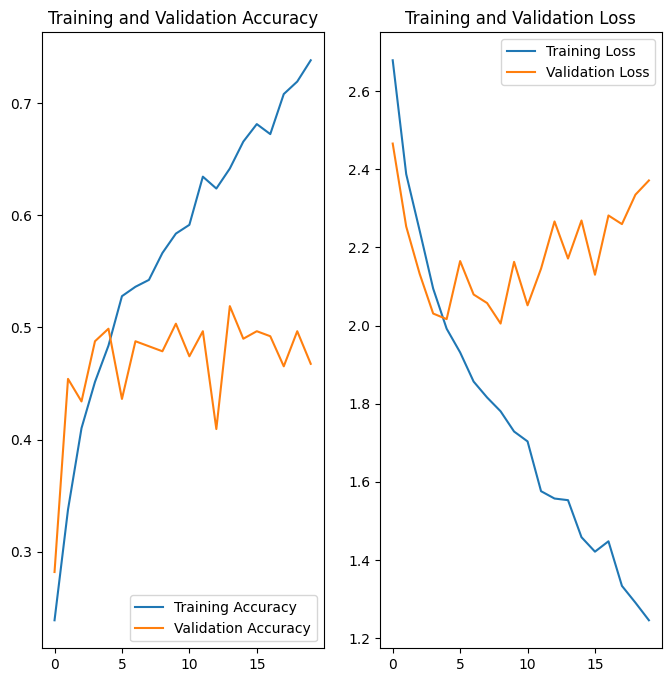

In [16]:
### Visualizing the train and val accuracy, train and val_loss

acc = history.history['accuracy']                              ## Training accuracy
val_acc = history.history['val_accuracy']                      ## Validation accuracy

loss = history.history['loss']                                 ## Training loss
val_loss = history.history['val_loss']                         ## validation loss

epochs_range = range(epochs)


### Plot for training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### Plot for training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
### DataFrame to store values
res = pd.DataFrame(columns=['Experiment','acc','val_acc'])
res.loc[len(res)] = ['Simple Model',acc[-1],val_acc[-1]]
res

,Experiment,acc,val_acc
0,Simple Model,0.738281,0.467562


- Inference
1. The model is clearly overfitting, it is mugging up all the contents.

#### 4: Data Augmentation

In [18]:
## Defining data augmentation layer
data_augmentation = Sequential([
    RandomFlip("horizontal",input_shape=(img_height,img_width,3)),         ## Random flipping the images horizontally
    RandomRotation(0.1),                                                   ## Random Rotation with a probability of 0.1
    RandomZoom(0.1)                                                        ## Random Zoom with a probability of 0.1
    ]
    )

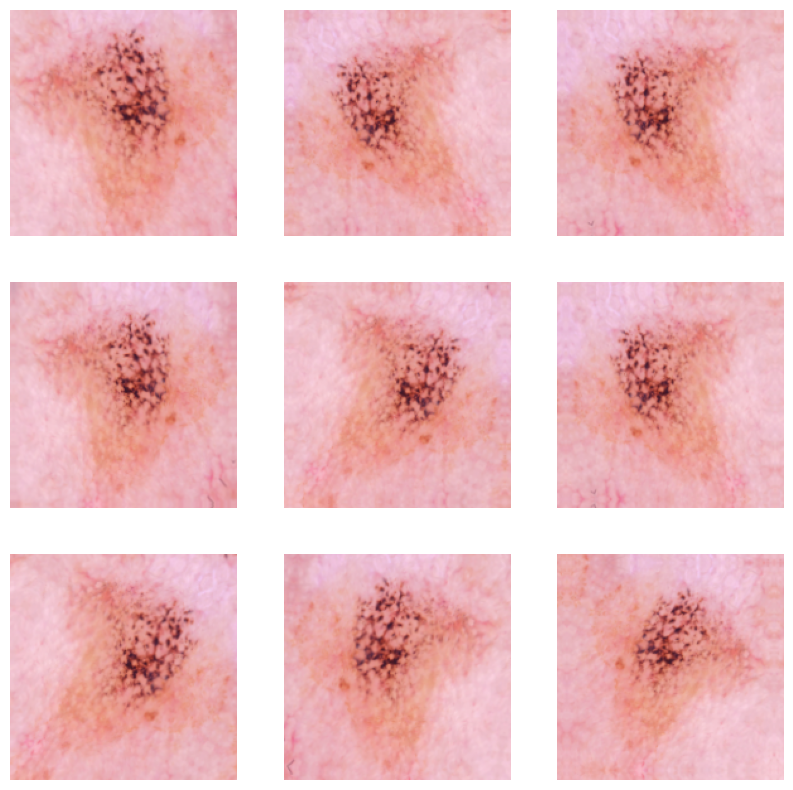

In [19]:
## Visualizing data augmentation applied on a single instance of image several times
plt.figure(figsize=(10, 10))
for image,labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[15].numpy().astype('uint8'))
        plt.axis("off")

In [20]:
### Creating the model using augmentation layer
model = Sequential([
  data_augmentation,                           ## augmentation layer added
  normalizing_layer,
  Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height,img_width,3)),
  MaxPool2D(pool_size=(2,2)),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.25),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
 ])

In [21]:
## compiling the model
model.compile(
  optimizer=keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(train_ds,validation_data=val_ds,
                  epochs=20 )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 5s 33ms/step - loss: 2.0726 - accuracy: 0.2857 - val_loss: 1.7609 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6596 - accuracy: 0.3912 - val_loss: 1.7081 - val_accuracy: 0.3893
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6007 - accuracy: 0.4208 - val_loss: 1.4791 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4600 - accuracy: 0.4894 - val_loss: 1.4140 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3997 - accuracy: 0.5078 - val_loss: 1.3851 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3371 - accuracy: 0.5296 - val_loss: 1.3869 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3677 - accuracy: 0.5229 - val_loss: 1.3945 - val_accuracy: 0.5168
Epoch 8/20
56/56 [======

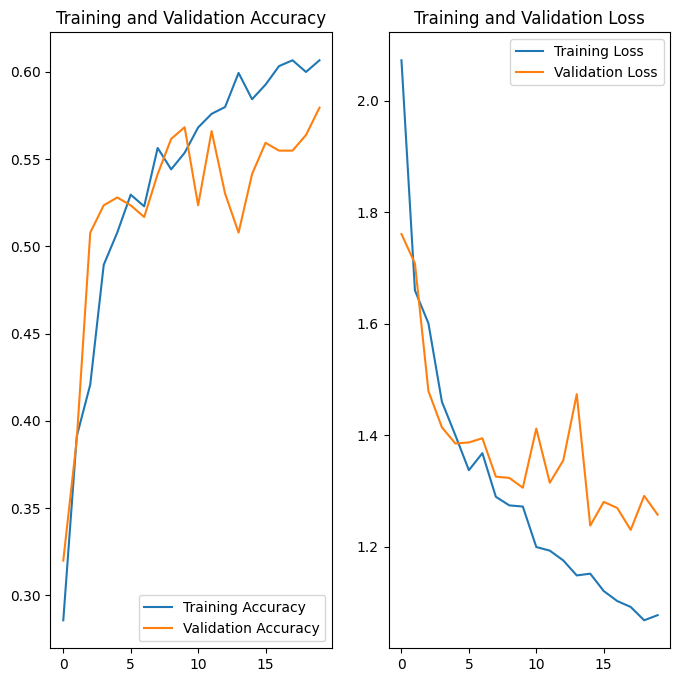

In [22]:
## Visualizing the Acc and loss of the model trained

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


## Plotting the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

## Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [23]:
### Updating the dataframe
res.loc[len(res)] = ['Simple+Aug',acc[-1],val_acc[-1]]
res

,Experiment,acc,val_acc
0,Simple Model,0.738281,0.467562
1,Simple+Aug,0.606585,0.579418


- Inference
1. Clearly the model is performing well on the validation set however the training accuracy is still low. Let's add a layer of dropout also and check how does it impact the model.

#### 5. Dropout

In [24]:
### Creating the model by adding a Dropout layer
model = Sequential([
  data_augmentation,
  normalizing_layer,
  Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height,img_width,3)),
  MaxPool2D(pool_size=(2,2)),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.25),                                   ### Dropout layer
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
 ])

In [25]:
## compiling the model
model.compile(
  optimizer=keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(train_ds,validation_data=val_ds,
                  epochs=20 )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 4s 32ms/step - loss: 1.8882 - accuracy: 0.3181 - val_loss: 1.7751 - val_accuracy: 0.3624
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6099 - accuracy: 0.4213 - val_loss: 1.5501 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4552 - accuracy: 0.4872 - val_loss: 1.4323 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3938 - accuracy: 0.5112 - val_loss: 1.5338 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3963 - accuracy: 0.5000 - val_loss: 1.4085 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.2993 - accuracy: 0.5374 - val_loss: 1.3231 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3368 - accuracy: 0.5391 - val_loss: 1.3496 - val_accuracy: 0.5190
Epoch 8/20
56/56 [======

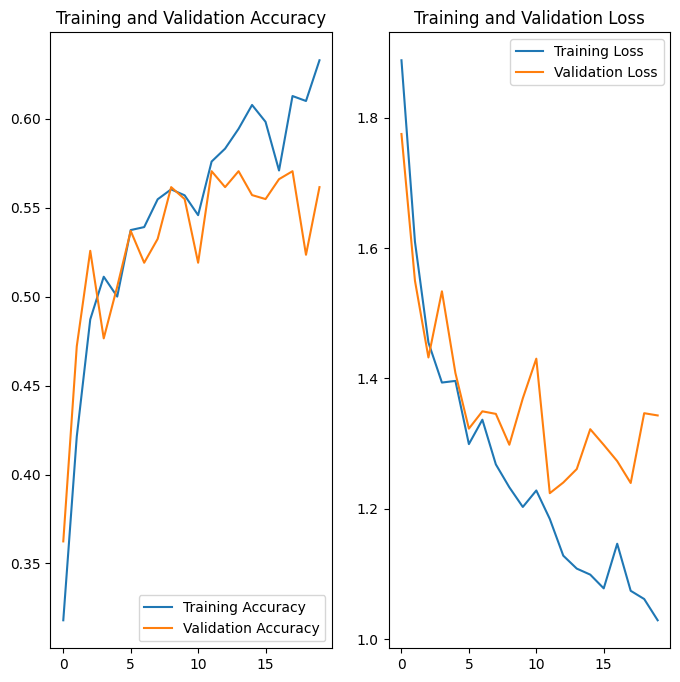

In [26]:
## Visualizing the Acc and loss of the model trained

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


## Plotting the Training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

## Plotting the Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [27]:
### Updating the dataframe
res.loc[len(res)] = ['Simple+Aug+Dropout',acc[-1],val_acc[-1]]
res

,Experiment,acc,val_acc
0,Simple Model,0.738281,0.467562
1,Simple+Aug,0.606585,0.579418
2,Simple+Aug+Dropout,0.632812,0.561521


Inference
- There isn't any significant improvement hwoever the training and val accuracy increase slightly.

#### 6. Batch Normalization

In [28]:
### Adding batch Normalization in one of the layers
model = Sequential([
  data_augmentation,
  normalizing_layer,
  Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height,img_width,3)),
  MaxPool2D(pool_size=(2,2)),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),                      ## Added Batch Normalization
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.25),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
 ])

In [29]:
## compiling the model
model.compile(
  optimizer=keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(train_ds,validation_data=val_ds,
                  epochs=20 )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 5s 35ms/step - loss: 1.9077 - accuracy: 0.3940 - val_loss: 2.1779 - val_accuracy: 0.0492
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4506 - accuracy: 0.4794 - val_loss: 2.0413 - val_accuracy: 0.2371
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3649 - accuracy: 0.5084 - val_loss: 2.0695 - val_accuracy: 0.2438
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3070 - accuracy: 0.5268 - val_loss: 1.8593 - val_accuracy: 0.2975
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2902 - accuracy: 0.5296 - val_loss: 1.8124 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.2161 - accuracy: 0.5647 - val_loss: 1.8113 - val_accuracy: 0.3893
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.1344 - accuracy: 0.5993 - val_loss: 1.6535 - val_accuracy: 0.4922
Epoch 8/20
56/56 [======

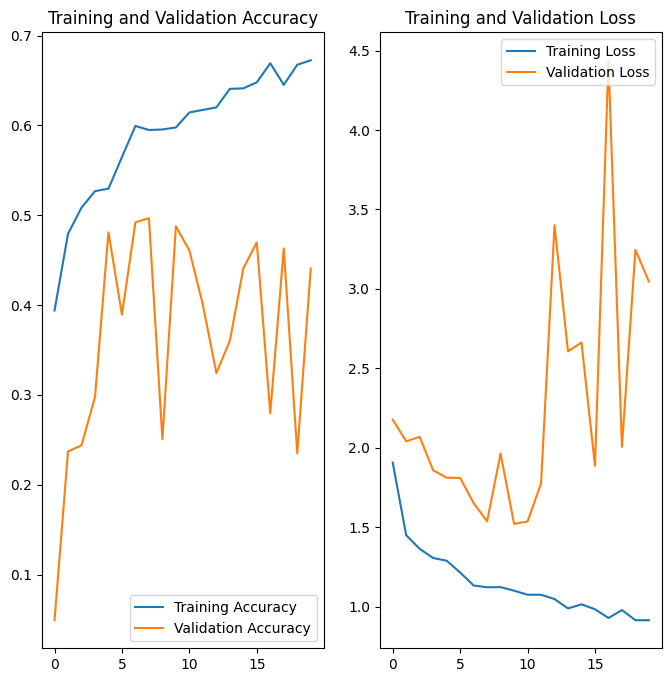

In [30]:
## Visualizing the Acc and loss of the model trained

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

### Plotting Training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


### Plotting Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [31]:
## Updating the result dataframe
res.loc[len(res)] = ['Simple+Aug+Drop+BN',acc[-1],val_acc[-1]]
res

,Experiment,acc,val_acc
0,Simple Model,0.738281,0.467562
1,Simple+Aug,0.606585,0.579418
2,Simple+Aug+Dropout,0.632812,0.561521
3,Simple+Aug+Drop+BN,0.672433,0.440716


- Inference
1. Batch Normalization is not improving the model in any sense , so we will remove it from the next iteration.

### 7. Class Imbalance

In [42]:
### Class segmentation in each folder
class_perc = pd.DataFrame(columns = ['Class_Name','Total_Image_Train','Train_perc','Total_Image_Test','Test_perc'])
for class_name in os.listdir(data_dir_train):
    train_class_len =len(list(data_dir_train.glob(class_name+'*/*.jpg')))
    len_train  = len(list(data_dir_train.glob('*/*.jpg')))
    test_class_len  = len(list(data_dir_test.glob(class_name+'*/*.jpg')))
    len_test = len(list(data_dir_test.glob('*/*.jpg')))
    class_perc.loc[len(class_perc)] = [class_name,train_class_len,(train_class_len/len_train)*100,test_class_len,(test_class_len/len_test)*100]
class_perc.loc[len(class_perc)] = ['Total',class_perc['Total_Image_Train'].sum(),class_perc['Train_perc'].sum(),class_perc['Total_Image_Test'].sum(),class_perc['Test_perc'].sum()]
class_perc['Total_dist'] = class_perc['Total_Image_Train']+class_perc['Total_Image_Test']
class_perc

,Class_Name,Total_Image_Train,Train_perc,Total_Image_Test,Test_perc,Total_dist
0,pigmented benign keratosis,462,20.634212,16,13.559322,478
1,dermatofibroma,95,4.242966,16,13.559322,111
2,squamous cell carcinoma,181,8.083966,16,13.559322,197
3,vascular lesion,139,6.208129,3,2.542373,142
4,basal cell carcinoma,376,16.793211,16,13.559322,392
5,actinic keratosis,114,5.091559,16,13.559322,130
6,melanoma,438,19.562305,16,13.559322,454
7,seborrheic keratosis,77,3.439035,3,2.542373,80
8,nevus,357,15.944618,16,13.559322,373
9,Total,2239,100.000000,118,100.000000,2357


<ipython-input-52-403db7ebec7a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= class_perc['Class_Name'][:-1],x=class_perc['Total_dist'][:-1],palette='viridis')


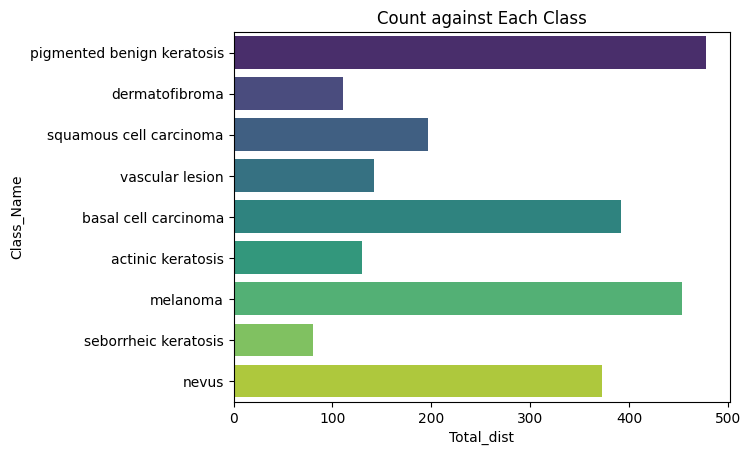

In [52]:
### Plotting each class vs the count
plt.figure()
sns.barplot(y= class_perc['Class_Name'][:-1],x=class_perc['Total_dist'][:-1],palette='viridis')
plt.title('Count against Each Class')
plt.show()


- Inference
1. seborrheic keratosis class	has the least number of samples
2. pigmented benign keratosis	is the class which has proportionately high number of instances.

#### Handling Class imbalance

In [53]:
# Importing augmentor
!pip install augmentor

In [54]:
## we can go through each class in the Train folder and make all of the images equal, The largest dataset we have is 438 for melanoma, let's make each folder contain 438 images
import Augmentor

for class_name in class_names:
    ## path to the data
    path_to_data = str(data_dir_train)+'/'+class_name
    length = len(list(data_dir_train.glob(class_name+'*/*.jpg')))
    ### initiate the augmentor object
    p  = Augmentor.Pipeline(path_to_data)
    ### Adding operations to existing pipeline
    # First, we add a horizontal flip operation to the pipeline:
    p.flip_left_right(probability=0.4)

    # Now we add a vertical flip operation to the pipeline:
    p.flip_top_bottom(probability=0.8)

    # Add a rotate90 operation to the pipeline:
    p.rotate90(probability=0.1)

    ## Creating 500 samples for each class_label
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB14657700>: 100%|██████████| 500/500 [00:04<00:00, 115.03 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB1465CAF0>: 100%|██████████| 500/500 [00:03<00:00, 125.24 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB147718A0>: 100%|██████████| 500/500 [00:06<00:00, 75.65 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FBB1468FF70>: 100%|██████████| 500/500 [00:13<00:00, 36.05 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FBB1B29B2E0>: 100%|██████████| 500/500 [00:13<00:00, 37.14 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=450x600 at 0x7FBB1A1E2890>: 100%|██████████| 500/500 [00:06<00:00, 81.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBB147E6C50>: 100%|██████████| 500/500 [00:08<00:00, 59.23 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB146B0400>: 100%|██████████| 500/500 [00:05<00:00, 88.55 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB1468E170>: 100%|██████████| 500/500 [00:07<00:00, 62.66 Samples/s]


In [55]:
print(f"# of images added:{len(list(data_dir_train.glob('*/output/*.jpg')))}")

# of images added:4500


### Creating a new set of train and val set from the newly created images

In [56]:
## Using 80% of the images for training and the other for validation
train_ds_new,val_ds_new = image_dataset_from_directory(directory=data_dir_train,
                             labels='inferred',   ## labels will be automatically detected with subdirectories
                             class_names=None,
                             batch_size=32,
                             image_size=(img_height, img_width),
                             seed=123,
                             shuffle=True,
                             validation_split=0.2,
                             subset='both'
                            )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.


In [57]:
# AutoTune for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds_new = train_ds_new.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_new = val_ds_new.cache().prefetch(buffer_size=AUTOTUNE)

### 8. Final Model

In [175]:
### Building the CNN
model = Sequential([
  data_augmentation,                                                                  ## data augmentation
  normalizing_layer,                                                                  ## normalizing
  Conv2D(16, 3, padding='same', activation='relu',input_shape=(img_height,img_width,3)),
  MaxPool2D(pool_size=(2,2)),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.25),                                                                      ### Dropout layer
  Flatten(),      ## Flattening
  Dense(128, activation='relu'),                                                     ## Dense layer
  Dense(num_classes, activation='softmax')                                           ## output layer and softmax activation function
 ])

In [176]:
## Model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [177]:
## compiling the model
model.compile(
  optimizer=keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Training the model
history = model.fit(train_ds_new,validation_data=val_ds_new,
                  epochs=epochs )

Epoch 1/20
169/169 [==============================] - 7s 29ms/step - loss: 1.8496 - accuracy: 0.3014 - val_loss: 1.5733 - val_accuracy: 0.4388
Epoch 2/20
169/169 [==============================] - 5s 27ms/step - loss: 1.4916 - accuracy: 0.4351 - val_loss: 1.5300 - val_accuracy: 0.4350
Epoch 3/20
169/169 [==============================] - 5s 29ms/step - loss: 1.3566 - accuracy: 0.4790 - val_loss: 1.3804 - val_accuracy: 0.4640
Epoch 4/20
169/169 [==============================] - 5s 28ms/step - loss: 1.2909 - accuracy: 0.5030 - val_loss: 1.2748 - val_accuracy: 0.5316
Epoch 5/20
169/169 [==============================] - 5s 28ms/step - loss: 1.2490 - accuracy: 0.5287 - val_loss: 1.2090 - val_accuracy: 0.5301
Epoch 6/20
169/169 [==============================] - 5s 29ms/step - loss: 1.1950 - accuracy: 0.5438 - val_loss: 1.1834 - val_accuracy: 0.5427
Epoch 7/20
169/169 [==============================] - 5s 28ms/step - loss: 1.1389 - accuracy: 0.5647 - val_loss: 1.1947 - val_accuracy: 0.5382

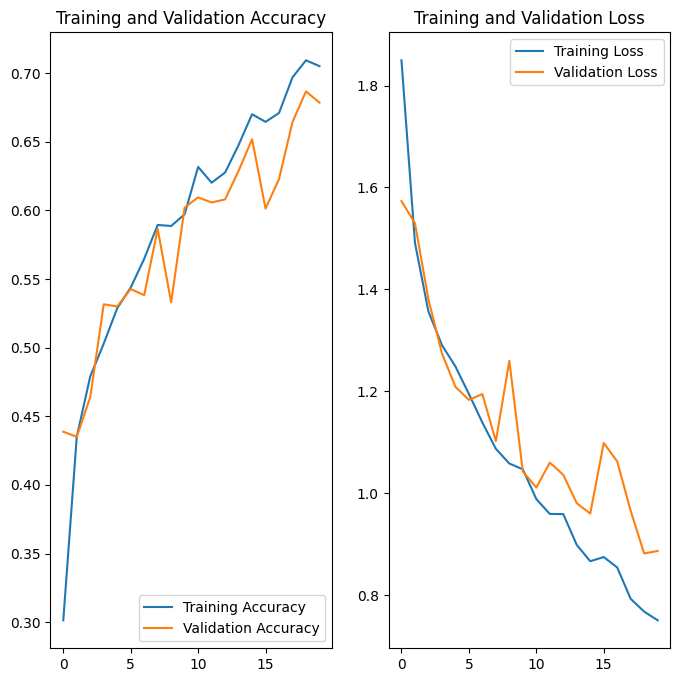

In [178]:
## Visualizing the Acc and loss of the model trained

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


##Plotting the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

##Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Inference
1. Accuracy- The training and the validation accuracy are hugging each other closely. This definitely means that the model is able to generalize the learnings on an unseen data.
2. Loss- When considering the loss, The loss at 10 epoch is very similar however after that the training loss is decreasing in comparison to that of Test loss.
3. We have got a validation accuracy of 67.85% however comparing it to the training accuracy of 70.5% it is good since we are able to generalize on the unseen data.

In [180]:
### Updating the result dataframe
res.loc[len(res)] = ['Handled_Imb+Simple+Aug+Drop',acc[-1],val_acc[-1]]
res

,Experiment,acc,val_acc
0,Simple Model,0.738281,0.467562
1,Simple+Aug,0.606585,0.579418
2,Simple+Aug+Dropout,0.632812,0.561521
3,Simple+Aug+Drop+BN,0.672433,0.440716
4,Handled_Imb+Simple+Aug+Drop,0.705119,0.678545


#### Test set

In [181]:
## defining the train data set path
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')


## Importing the images from the test directory and defining test set
test_ds = image_dataset_from_directory(directory=data_dir_test,
                            labels='inferred',
                             class_names=None,
                             batch_size=32,
                             image_size=(img_height, img_width),
                             seed=123,
                             shuffle=True,
                        )

Found 118 files belonging to 9 classes.


In [183]:
## Evaluating model on the test set
prediction = model.evaluate(train_ds)
print(f"Loss on the test set:{np.round(prediction[0],2)}")
print(f"Accuracy on the test set:{np.round(prediction[1]*100,2)}%")

56/56 [==============================] - 0s 9ms/step - loss: 0.8313 - accuracy: 0.6830
Loss on the test set:0.83
Acc on the test set:68.3%


- Inference
1. We are getting the accuracy on the test set as 68.3% which is good since the val_accuracy we have got is 67.85%.
2. The model is not overfitting any sense. Therefore we can say here that we have solved the problem we were getting in the initial stages.

#### 9. Predictions


In [207]:
## Range 0-8
select_class =np.random.randint(1,9)

## Defining the train_image_path
# train_image_path = str(list(data_dir_train.glob(class_names[select_class]+'*/*.jpg'))[0])
test_image_path = str(list(data_dir_test.glob(class_names[select_class]+'*/*.jpg'))[0])


### Function to load image
image = Image.open(test_image_path)
image = image.resize((img_height,img_width))   ## resizing to 180,180,3
image_arr = np.array(image)   ## Converting into array
img = np.expand_dims(image_arr,0)  ## Adding an extra dimension to make prediction


## Prediction
predictions = model.predict(img)
predicted_class=class_names[np.argmax(predictions)]   ## will give index having max probability
print(f'Predicted Class:{predicted_class}')
print(f'Actual Class:{class_names[select_class]}')
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(predicted_class,np.max(predictions)*100)
)

1/1 [==============================] - 0s 17ms/step
Predicted Class:vascular lesion
Actual Class:vascular lesion
This image most likely belongs to vascular lesion with a 100.00 percent confidence.
